# Data Scraping and The Movie Database Api


Final Project Submission

Student name: Amir M Edris & Yasir Karim

Student pace: full time

Scheduled project review date/time: 10:00 am, Aug 21st, 2020

Instructor name: Fangfang Lee


## Data Scraping From Box Office Mojo

So I wanted to collect data from the website box office mojo to make a dataset of the top grossing movies all time. 

The page that has this information can be found 
here:https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/    

To get this data we are gonna have python send a request for the information of that page iterate through it and look for the markers unique to the data that we wanna collect. We need python to do this for every row and every page.

I wanted to make the same dataset as JVasquez5's which can be found:https://github.com/JVasquez5/dsc-mod-1-project-v2-1-nyc01-dtsc-ft-051120/blob/master/Data_Web_Scraping_%26_API.ipynb. From him I used the tags to find the data found in the function BOMscrap later and merging both data sets I implemented them differently but I learned from reading his project.


In [535]:
#First import the modules that we are gonna be using below
import requests #To make http requests
from bs4 import BeautifulSoup as bs #To make soup and be able to extract data from our requests.
import pandas as pd# To store look at and manipulate our data
import json# To properly read the results of api requests
pd.set_option('display.float_format', lambda x: '%.1f' % x)

   When you go to the next page on the website I noticed the end of the link changes to
'?offset=200'. I figured that that was the amount of rows to skip since it increased by 200 per page with 800 being the last page. So instead of making something that runs 5 times we can just use a loop.

In [536]:
#added a variable for the link so that we could use the .format() methood later
link = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/{}'
#make a variable x that is the value that we will pass into the offset attribute
x = 0
#make a list of the 5 pages we will use.
linklist = []

while x < 1000:#                            While we arent x doesnt equal 1000 we havent got all
    command= '?offset={}'.format(x)#   the pages so we set the offset to our next page 200 rows
    y = link.format(command)#.         and clone the link thats empty name it y and add our offset             
    linklist.append(y)#                we then add that list to the end of the dictionary and
    x+=200#                            and finally add 200 to x so we get the next 200 
#                                      until we finish.
print(linklist)


['https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=0', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=200', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=400', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=600', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=800']


Next we are gonna make a function that will go through the data that we will get from Box Office Movies after it goes through beautiful soup and have it give us the rows of data.

In [537]:
# next we are gonna make a function that will take in the result of the request and give
# you the rows of data
def BOMscrap(entry):
    movie_list = []#final list
    for record in entry.findAll("tr"): #             for every record that has the tag 'tr' in
        row = [x.text for x in record.findAll("td")]#our entry make a row of all the info in that 
        for a in record.findAll('a', href=True):#   record using the 'td' tag. if a link in the 
            if a['href'].startswith('/title/'):#    record starts with title remove the link portion
                row.append(a['href'][7:16])#        and add it to our current row. finally if the row
        if len(row)>0:#                             isnt empty add it to our list of rows.
            movie_list.append(row)
    return movie_list

So now we have a function that can take in processed data from a link and we have a list of links. The next thing we have to do is put our data through beautiful soup so that we can use our function to crunch it down to only the information that we want then add it to a list fulllist which will contain all 5 pages worth of data.

In [538]:
fulllist = []#                                for every link in our list linklist get the html
for link in linklist:#                     data for that link(page info) and turn it into a 
    r = requests.get(link)#                beautiful soup object and make a temporary
    soup = bs(r.content,'html.parser')#    variable 'page' which is equal to that pages 200
    page = BOMscrap(soup)#                 rows of data and add the rows to our list fulllist.
    fulllist += page


So now we sould have a thousand rows of data, we are gonna verify this and make a list of the names of the columns that we have extracted.

In [539]:
print(len(fulllist))#make sure are assumtion is right
header = ['Rank', 'Title', 'Worldwide_Lifetime_Gross', #making the columns
          'Domestic_Lifetime_Gross', 'Domestic_Percentage', 
          'Foreign_Lifetime_Gross', 'Foreign_Lifetime_Percentage', 
          'Year', 'imdb_id']

1000


Now that we have made a header list we can use the modules pandas(pd) to make a dataframe(completed_df) that will hold our data.

In [540]:
completed_df = pd.DataFrame(fulllist, columns = header)# make a dataframe from the listoflist fulllist
completed_df.head()

,Rank,Title,Worldwide_Lifetime_Gross,Domestic_Lifetime_Gross,Domestic_Percentage,Foreign_Lifetime_Gross,Foreign_Lifetime_Percentage,Year,imdb_id
0,1,Avengers: Endgame,"$2,797,800,564","$858,373,000",30.7%,"$1,939,427,564",69.3%,2019,tt4154796
1,2,Avatar,"$2,790,439,000","$760,507,625",27.2%,"$2,029,931,375",72.8%,2009,tt0499549
2,3,Titanic,"$2,195,169,869","$659,363,944",30%,"$1,535,805,925",70%,1997,tt0120338
3,4,Star Wars: Episode VII - The Force Awakens,"$2,068,224,036","$936,662,225",45.3%,"$1,131,561,811",54.7%,2015,tt2488496
4,5,Avengers: Infinity War,"$2,048,359,754","$678,815,482",33.1%,"$1,369,544,272",66.9%,2018,tt4154756


Ok so we have 1000 movies and some information about how much money they have made, when they were made, etc. But thats not enough info for every row to do the analysis that we wanted to do so we are gonna use the series or column 'imdb_id' with a movie database api to contact the site tmdb and request some more info

In [541]:
movieids = completed_df.imdb_id#Store the series for ease
tmdb_list = []
for id in movieids:#Check every movie and get read the json turn it to a dict and add it to our new data list
    response = requests.get("https://api.themoviedb.org/3/movie/" + id + "?api_key=" + "e69606ff3cabd3ebbba0d97046bc81ba" + "&language=en-US")
    data = response.json()
    tmdb_list.append(data)


Now we have a list of dictionaries that we can also convert to a dataframe.

In [542]:
tmdbdf=pd.DataFrame(tmdb_list)
tmdbdf.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534.0,tt4154796,en,Avengers: Endgame,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Part of the journey is the end.,Avengers: Endgame,False,8.3,14644.0,NaN,nan,NaN
1,False,/bIL7ENqh1egWTxN41sM2W42JqPc.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995.0,tt0499549,en,Avatar,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.4,21864.0,NaN,nan,NaN
2,False,/6VmFqApQRyZZzmiGOQq2C92jyvH.jpg,None,200000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",,597.0,tt0120338,en,Titanic,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Nothing on Earth could come between them.,Titanic,False,7.9,17528.0,NaN,nan,NaN
3,False,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607.0,tt2488496,en,Star Wars: The Force Awakens,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.4,14818.0,NaN,nan,NaN
4,False,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/avengers-infinit...,299536.0,tt4154756,en,Avengers: Infinity War,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An entire universe. Once and for all.,Avengers: Infinity War,False,8.3,19358.0,NaN,nan,NaN


Now though we have alot more columns for each movie but most of them we don't need so we are just gonna go ahead and drop those columns

In [543]:
tmbddf = tmdbdf.drop(['backdrop_path', 'homepage', 
                             'id', 'original_title', 'overview', 
                             'poster_path', 'revenue', 'status',
                             'spoken_languages', 'tagline','title',
                             'status_code',
                             'status_message', 'video'], axis = 1)#axis specifies column
tmbddf.head()

,adult,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,vote_average,vote_count,success
0,False,"{'id': 86311, 'name': 'The Avengers Collection...",356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",tt4154796,en,36.4,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-04-24,181.0,8.3,14644.0,NaN
1,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0499549,en,35.1,"[{'id': 444, 'logo_path': '/42UPdZl6B2cFXgNUAS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,162.0,7.4,21864.0,NaN
2,False,None,200000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",tt0120338,en,28.2,"[{'id': 4, 'logo_path': '/fycMZt242LVjagMByZOL...","[{'iso_3166_1': 'US', 'name': 'United States o...",1997-11-18,194.0,7.9,17528.0,NaN
3,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt2488496,en,29.2,"[{'id': 1634, 'logo_path': None, 'name': 'True...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,136.0,7.4,14818.0,NaN
4,False,"{'id': 86311, 'name': 'The Avengers Collection...",300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",tt4154756,en,77.3,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2018-04-25,149.0,8.3,19358.0,NaN


We are gonna want to clean our data because alot of it is unusable in this state and also we want one big data frame not two smaller ones especially since they have data for the same movies.

In [544]:
tmdbdf.dropna(axis=0, how="all", inplace=True)#Drop anything that is null
merged_df = completed_df.merge(tmdbdf, on='imdb_id', how='outer')#add the columns of the rows that have the same id
merged_df = merged_df[0:1000]#get rid of some extra rows.


Ok our data is more or less ready. We dont want to have to keep rerunning this so we should just save it locally so that we can work on it from another file if we want.

In [545]:
merged_df.to_csv('Data/better-data.csv')


# videogame data cleaning portion

In [546]:
#bring in the data and show the first few coloums to make sure that nothing is broken
vgdf = pd.read_csv('vgsales.csv')
vgdf.shape

(16598, 11)

In [547]:
#function to check if a game is a microsoft owned game
def ismicrosoft(PublisherName):
    microsoftaliases =['Xbox Game Studios','Microsoft Game Studios','Microsoft Studios','Microsoft']
    Pubname = PublisherName.replace(' ','').upper()
    aliases = [x.replace(' ','').upper() for x in microsoftaliases]
    for name in aliases:
        if name == Pubname:
            return True
    return False
   
ismicrosoft('Xbox Game Studios')    

True

In [548]:
vgdf.isnull().sum()#take a look at our at potential missing values


Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [549]:
vgdf = vgdf.dropna()
print(vgdf.shape,vgdf.isnull().sum())#get rid of them and make sure they are gone

(16291, 11) Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


In [550]:
vgdf.Genre.value_counts()
vgdfg = vgdf
vgdfg#So I made a specific dataframe were the values are repeated for every genre they have. since values are repeated
#Im only gonna use this for genre related things

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.5,29.0,3.8,8.5,82.7
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.1,3.6,6.8,0.8,40.2
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.8,12.9,3.8,3.3,35.8
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.8,11.0,3.3,3.0,33.0
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.3,8.9,10.2,1.0,31.4
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.0,0.0,0.0,0.0,0.0
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.0,0.0,0.0,0.0,0.0
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.0,0.0,0.0,0.0,0.0
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.0,0.0,0.0,0.0,0.0


In [551]:
translations = {'Action':['Action','Science Fiction','Horror','Thriller'],'Sports':['Documentary','Action','History']
                ,'Misc':['Family','Animation']
                ,'Role-Playing':['Action','Adventure','Fantasy','Science Fiction']
                ,'Shooter':['Action','Adventure','War','Science Fiction','Thriller','Horror']
                ,'Adventure':['Action','Adventure','Science Fiction','Fantasy'],'Racing':['Thriller','Action','Family','Crime']
                ,'Platform':['Family','Animation','Music'],'Simulation':['History','Science Fiction']
                ,'Fighting':['Action','Family'],'Strategy':['Mystery','Action','Crime']
                ,'Puzzle':['Mystery','Horror']}#We have to convert the game genres to the movie genres which is unfortunate
#because the movies have about 3-5 where as the games have 1 each and most of them would actually be multiple. This 
#probably isnt the best solution but Im going to use the dictionary above and replace specific game genres with a list
#im then just gonna repeat the row for every row. This is def not a good way to do this but I noticed this problem too late.
def translate(genre):
    x = translations[genre]
    return x
    #['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
    #   'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
    #   'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']
translate('Sports')    
    

['Documentary', 'Action', 'History']

In [552]:
vgdf['Microsoft'] = vgdf['Publisher'].map(lambda x: 'Microsoft' if ismicrosoft(x) else 'useless')
#add a Column that lets us know if a game is owned by microsoft which uses the function we made earlier to compare
#a value to the know microsoft names




In [553]:
vgcols = [x for x in vgdf]#this will look at the list of genres in a row and add as many rows as it takes for each
#to have one genre
vggenredata = list(vgdf.values)
print(vggenredata[0][4])
print(len(vggenredata))
g = []
length = len(vggenredata)
for i in range(0,length):
    templist = translate(vggenredata[i][4])
    for j in templist:
        a = vggenredata[i]
        z = '{}'.format(j)
        a = list(a)
        a[4]=z
        g.append(a[1:])
   
vgdfg = pd.DataFrame(g,columns = vgcols[1:])
vgdfg = vgdfg[vgdfg['Microsoft']!='useless']
vgdfg.head()


Sports
16291


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Microsoft
49,Kinect Adventures!,X360,2010.0,Family,Microsoft Game Studios,15.0,4.9,0.2,1.7,21.8,Microsoft
50,Kinect Adventures!,X360,2010.0,Animation,Microsoft Game Studios,15.0,4.9,0.2,1.7,21.8,Microsoft
164,Halo 3,X360,2007.0,Action,Microsoft Game Studios,8.0,2.8,0.1,1.2,12.1,Microsoft
165,Halo 3,X360,2007.0,Adventure,Microsoft Game Studios,8.0,2.8,0.1,1.2,12.1,Microsoft
166,Halo 3,X360,2007.0,War,Microsoft Game Studios,8.0,2.8,0.1,1.2,12.1,Microsoft


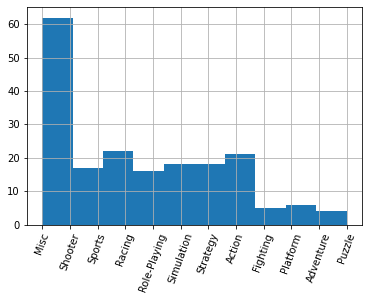

In [557]:
#I was kinda just messing around for some of these graphs to learn they arent all usefull
#hist of microsoft ips
MSIP = vgdf[vgdf['Microsoft'] != 'useless']
MSIP['Genre'].hist(xrot = 70)

In [556]:
MSIP[MSIP['Name']=='Halo 3']
#making sure halo has the right info because its their biggest title

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Microsoft
43,44,Halo 3,X360,2007.0,Shooter,Microsoft Game Studios,8.0,2.8,0.1,1.2,12.1,Microsoft


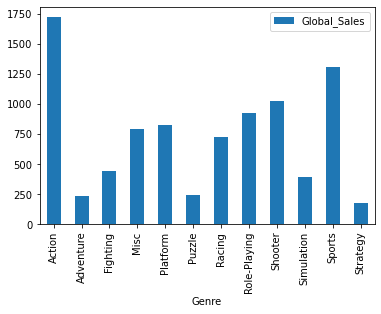

In [408]:
vgdfg.groupby('Genre').sum().plot.bar(y ='Global_Sales')
#Trying to see which genre they have more experience selling in

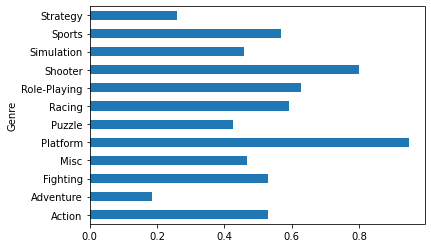

In [409]:
vgdfg.groupby('Genre').Global_Sales.mean().plot.barh()
#same chart just horizontal and showing avgs now

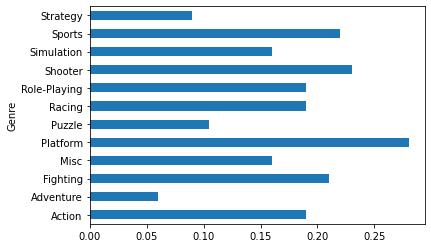

In [410]:
vgdfg.groupby('Genre').Global_Sales.median().plot.barh()
#see if the median vastly changes anything

Next going to try and translate the game genres to movie genres and clean the movie genres column so that it makes sense

In [411]:
xyz = merged_df[(merged_df['genres'] != float)]
xyz = xyz.drop(113,axis = 0)
xyz = xyz.drop(254,axis = 0)#nan values
xyz = xyz.drop(287,axis = 0)
xyz = xyz.drop(630,axis = 0)
xyz
xyz['genres'] = xyz['genres'].apply(lambda x: [y['name'] for y in x])
xyz['genres']
#this is going back to what I did for the genre data tables just for the multiple genres in movies instead of games now

0                   [Adventure, Science Fiction, Action]
1          [Action, Adventure, Fantasy, Science Fiction]
2                                       [Drama, Romance]
3          [Action, Adventure, Science Fiction, Fantasy]
4                   [Adventure, Action, Science Fiction]
                             ...                        
995                                   [Action, Thriller]
996                                     [Family, Comedy]
997                                      [Drama, Comedy]
998    [War, History, Action, Adventure, Drama, Romance]
999                                     [Drama, Romance]
Name: genres, Length: 996, dtype: object

In [415]:
genredata = list(xyz.values)#

In [416]:
imtiredanddontknowwhatimdoing = []#Me realizing im using pandas wrong
length = len(genredata)
for i in range(0,length):
    templist = genredata[i][13]
    for j in templist:
        a = genredata[i]
        a[13] = j
        imtiredanddontknowwhatimdoing.append(a)
#Pretty much the same thing as the block of code used in vgdfg
        

In [417]:
genredata = pd.DataFrame(data = imtiredanddontknowwhatimdoing, columns = ['Rank', 'Title', 'Worldwide_Lifetime_Gross', 'Domestic_Lifetime_Gross', 'Domestic_Percentage', 'Foreign_Lifetime_Gross', 'Foreign_Lifetime_Percentage', 'Year', 'imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'success', 'status_code', 'status_message'])
genredata['Worldwide_Lifetime_Gross'] = genredata['Worldwide_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Domestic_Lifetime_Gross'] = genredata['Domestic_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Foreign_Lifetime_Gross'] = genredata['Foreign_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Worldwide_Lifetime_Gross']#make a df from the list of lists we just made
#format some of the values properly


0       2797800564
1       2797800564
2       2797800564
3       2790439000
4       2790439000
           ...    
2988     167298192
2989     167298192
2990     167298192
2991     166842739
2992     166842739
Name: Worldwide_Lifetime_Gross, Length: 2993, dtype: int64

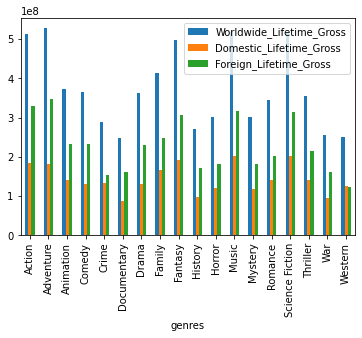

In [418]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').mean()
ybc.plot.bar()#for each of the movies in each genre get the avg value for these 3 columns and make a bar graph

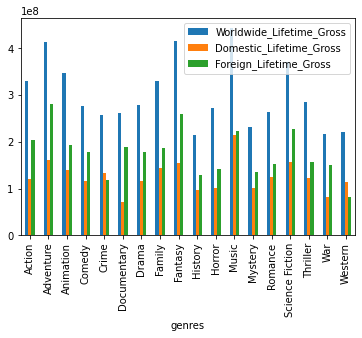

In [419]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').median()
ybc.plot.bar() #same thing but middle values instead of avg

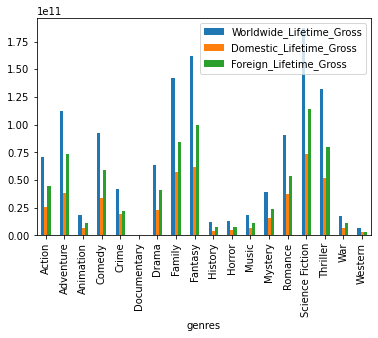

In [420]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').sum()
ybc.plot.bar()#agains same except sum instead of avg/median

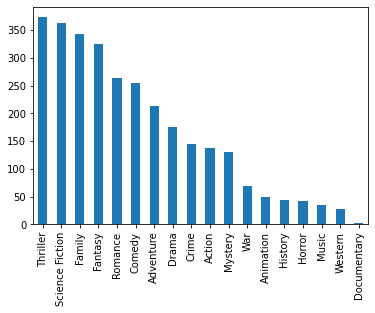

In [421]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']]
ybc.genres.value_counts().plot.bar()
#which genres were more popular






genres
Action       946.0
Adventure   1451.5
Animation    315.0
Comedy      1648.1
Crime        999.8
Name: vote_average, dtype: float64

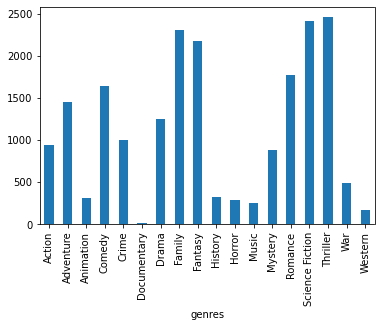

In [422]:
ybc = genredata.groupby('genres').vote_average.sum()
ybc.plot.bar()
ybc.head()
#the average rating of imdb users for the movies we have grouped by genres

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'],
      dtype='object', name='genres')

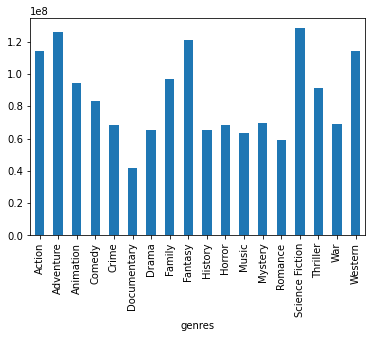

In [423]:
ybc = genredata.groupby('genres').budget.mean()
ybc.plot.bar()
ybc.head()
ybc.keys()
#avg budget for each 

genres
Action      110000000.0
Adventure   140000000.0
Animation   103000000.0
Comedy       76500000.0
Crime        60000000.0
Name: budget, dtype: float64

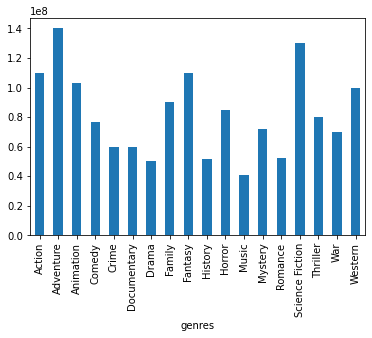

In [424]:
abc = genredata.groupby('genres').budget.median()
abc.plot.bar()
abc.head()
#same but median

genres
Action      10000000.0
Adventure          0.0
Animation   26500000.0
Comedy             0.0
Crime        6000000.0
Name: budget, dtype: float64

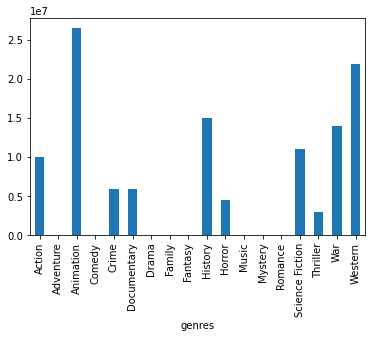

In [425]:
zxc =genredata.groupby('genres').budget.min()
zxc.plot.bar()
zxc.head()
#min value spent on a movie in each genre

genres
Action      356000000.0
Adventure   270000000.0
Animation   150000000.0
Comedy      230000000.0
Crime       200000000.0
Name: budget, dtype: float64

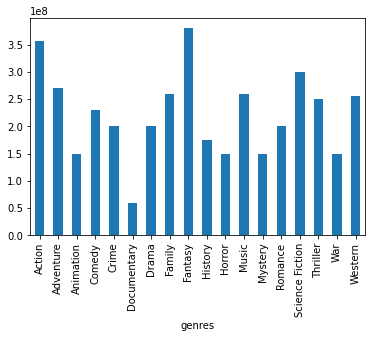

In [426]:
ubc = genredata.groupby('genres').budget.max()
ubc.plot.bar()
ubc.head()
#max value spent on a movie in a genre

In [427]:
asd = list(zip(ubc,ybc,abc,zxc))
#making a dataframe from these

In [428]:
asd = pd.DataFrame(asd, index = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'], columns = ['Most money spent on a movie','avg spent on all the movies in this genre','Middle value for all the movies in this genre','Least spent on the movie'] )

Text(0, 0.5, 'Money spent in 100 milions')

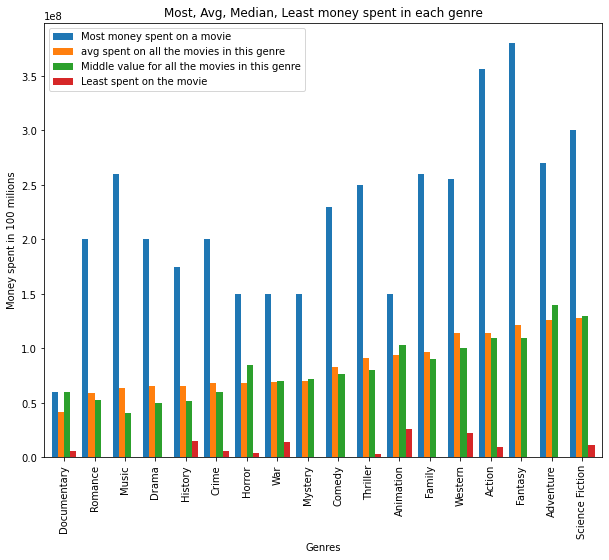

In [429]:
plot = asd.sort_values('avg spent on all the movies in this genre',ascending=True).plot(kind = 'bar',title = 'Most, Avg, Median, Least money spent in each genre',figsize=(10,8), width=0.8)
plot.set_xlabel('Genres')
plot.set_ylabel('Money spent in 100 milions')
#graphed all of the last 4 together and sorted them ascending by the sum values

In [558]:
rankings = vgdfg[vgdfg['Microsoft']=='Microsoft'].groupby('Genre')
OPT = rankings.apply(lambda x: x.sort_values('Global_Sales',ascending=False))
opt = OPT.reset_index(drop=True)
opt=opt.groupby('Genre').head(3)
viable_options=opt[['Genre','Name','Global_Sales']]
viable_options
#made a dataframe the represents the top three ips to chose form 


,Name,Global_Sales
0,Halo 3,12.1
1,Halo: Reach,9.9
2,Halo 4,9.8
130,Halo 3,12.1
131,Halo: Reach,9.9
132,Halo 4,9.8
177,Kinect Adventures!,21.8
178,Minecraft,9.2
179,Minecraft,2.4
217,Forza Motorsport 3,5.5


In [449]:
vgdf.to_csv('Data/vgdata.csv')
vgdfg.to_csv('Data/vgdatagenre.csv')
genredata.to_csv('Data/Genre.csv')
xyz.to_csv('Data/xyz.csv')
opt.to_csv('Data/opt.csv')
asd.to_csv('Data/asd.csv')#save the datframes locally